In [1]:
!pip install --upgrade numpy==1.25.2
!pip install --upgrade pandas_ta

[*********************100%***********************]  1 of 1 completed


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,151 (375.59 KB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.5063e-04 - val_loss: 0.0013
Epoch 2/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.1580e-06 - val_loss: 5.1797e-04
Epoch 3/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.1774e-06 - val_loss: 4.2249e-04
Epoch 4/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.5512e-06 - val_loss: 1.6134e-04
Epoch 5/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.7053e-06 - val_loss: 1.3608e-04
Epoch 6/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0128e-06 - val_loss: 3.5230e-04
Epoch 7/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.0648e-06 - val_loss: 1.2905e-04
Epoch 8/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.1139e-06 - val_loss: 2.3782e-04
Epoch 9/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.8365e-06 - val_loss: 3.8794e-04
Epoch 10/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.0447e-06 - val_loss: 2.6371e-04
Epoch 11/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.

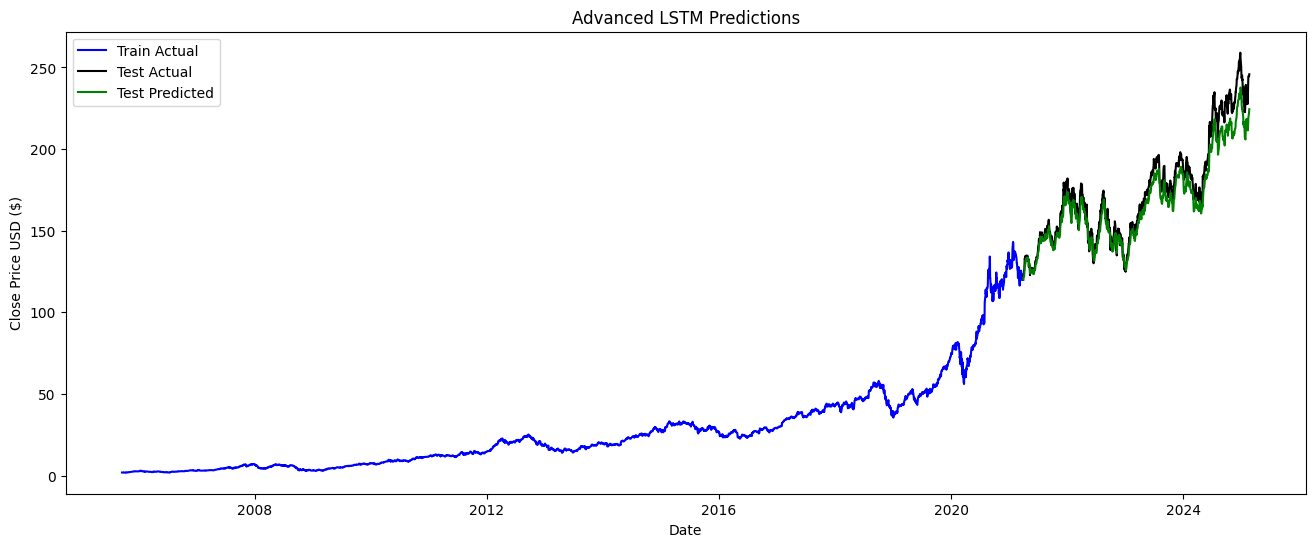

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from keras.models import Model
from keras.layers import LSTM, Dense, Activation, Input
from keras import optimizers
from keras.callbacks import EarlyStopping

np.random.seed(10)

def load_data_and_add_indicators(ticker='AAPL', start='2005-01-01', end='2025-02-21'):
    data = yf.download(tickers=ticker, start=start, end=end, auto_adjust=False)
    if data.empty:
        return pd.DataFrame()
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
    data['RSI'] = ta.rsi(data['Close'], length=15)
    data['EMAF'] = ta.ema(data['Close'], length=20)
    data['EMAM'] = ta.ema(data['Close'], length=100)
    data['EMAS'] = ta.ema(data['Close'], length=150)
    data.dropna(inplace=True)
    data = data[['Open','High','Low','Close','Adj Close','RSI','EMAF','EMAM','EMAS']]
    data.reset_index(inplace=True)
    return data

def create_sequences_and_split(df, backcandles=30):
    date_col = df['Date']
    numeric_df = df.drop('Date', axis=1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(numeric_df)
    n_features = numeric_df.shape[1]
    rows = data_scaled.shape[0]
    X, y = [], []
    for i in range(backcandles, rows):
        X.append(data_scaled[i-backcandles:i, :])
        y.append(data_scaled[i, 3])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    splitlimit = int(len(X) * 0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]
    date_seq = date_col[backcandles:].reset_index(drop=True)
    date_train = date_seq[:splitlimit]
    date_test = date_seq[splitlimit:]
    return X_train, X_test, y_train, y_test, date_train, date_test, scaler, n_features

def build_lstm(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(150)(lstm_input)
    x = Dense(1)(x)
    output = Activation('linear')(x)
    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mse')
    model.summary()
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, date_train, date_test, scaler, n_features, epochs=50, batch_size=8):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1, verbose=1, callbacks=[early_stop])
    y_pred_scaled = model.predict(X_test)
    full_pred = np.zeros((len(y_pred_scaled), n_features))
    full_pred[:, 3] = y_pred_scaled.flatten()
    inv_pred = scaler.inverse_transform(full_pred)
    predictions = inv_pred[:, 3]
    full_ytest = np.zeros((len(y_test), n_features))
    full_ytest[:, 3] = y_test.flatten()
    actual = scaler.inverse_transform(full_ytest)[:, 3]
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    print("\nModel Performance Metrics:")
    print(f" - MSE: {mse:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE: {mae:.4f}")
    print(f" - R² Score: {r2:.4f}")
    recent_days = 5
    print(f"\nRecent {recent_days} Days (Actual vs Predicted):")
    for i in range(len(actual) - recent_days, len(actual)):
        print(f"Day {i} => Actual: {actual[i]:.4f}, Predicted: {predictions[i]:.4f}")
    y_pred_train_scaled = model.predict(X_train)
    full_pred_train = np.zeros((len(y_pred_train_scaled), n_features))
    full_pred_train[:, 3] = y_pred_train_scaled.flatten()
    predictions_train = scaler.inverse_transform(full_pred_train)[:, 3]
    full_ytrain = np.zeros((len(y_train), n_features))
    full_ytrain[:, 3] = y_train.flatten()
    actual_train = scaler.inverse_transform(full_ytrain)[:, 3]
    plt.figure(figsize=(16, 6))
    plt.plot(date_train, actual_train, label='Train Actual', color='blue')
    plt.plot(date_test, actual, label='Test Actual', color='black')
    plt.plot(date_test, predictions, label='Test Predicted', color='green')
    plt.title('Advanced LSTM Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend()
    plt.show()

def main():
    df = load_data_and_add_indicators()
    if df.empty:
        return
    X_train, X_test, y_train, y_test, date_train, date_test, scaler, n_features = create_sequences_and_split(df)
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        return
    model = build_lstm(input_shape=(30, n_features))
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, date_train, date_test, scaler, n_features)

if __name__ == "__main__":
    main()
